### Imputation and Gap-Filling Logic (Dev)
Goal: Quantify gaps for each site to understand extent of the problem

## Imports and Paths

In [1]:
# install required modules quietly
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"
import math
import json

from pyspark.sql.functions import col
import pyspark.pandas as pd
from calendar import monthrange
from datetime import datetime
import io
from io import BytesIO
from tqdm import tqdm

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from datetime import date
today = str(date.today())

# Load locale custome modules
import sys
sys.path.append(os.path.abspath("../tools"))

from CloudIO.AzStorageClient import AzStorageClient
from data_pipeline_lib import *

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

required_packages = ['geopandas', 'pyspark', 'azure-storage-blob']

for p in required_packages: 
  try:
      __import__(p)
  except ImportError:
      %pip install {p} --quiet

MY_HOME_ABS_PATH = "/Users/jetcalz07/Desktop/MIDS/W210_Capstone/co2-flux-hourly-gpp-modeling"
root_dir =  MY_HOME_ABS_PATH
tmp_dir =  root_dir + os.sep + '.tmp'
raw_data_dir = tmp_dir
data_dir = root_dir + os.sep + 'data'
dataset_dir = root_dir + os.sep + 'data' + os.sep + 'datasets'
cred_dir = root_dir + os.sep + '.cred'
az_cred_file = cred_dir + os.sep + 'azblobcred.json'


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Connect to Azure

In [2]:
# Initialize Azure Storage Client
azStorageClient = AzStorageClient(az_cred_file)

# List blobs names under the container "data_full_half_hourly"
container_name = 'full-half-hourly-raw'
blob_name_list = azStorageClient.listBlobs(container_name)

### Define Functions

In [3]:
# Define features and target variables of the data pipelines
included_features = ['TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                     'datetime', 'year', 'month', 'day', 'hour', 'date',
                     'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 
                     'IGBP', 'koppen']
target_variable_qc = 'NEE_VUT_REF_QC'
target_variable = 'GPP_NT_VUT_REF'

In [4]:
# Load site data
def data_cleanup_eda(fname, site_name, site_fname, target, target_qc, features):
  # qc_flag_dtype = CategoricalDtype([0, 1, 2, 3], ordered=True)
  qc_flags_features = [s for s in features if "_QC" in s]

  # Iterate through each site:   
  # Get only `features` from file
  site_df = pd.read_csv(fname, usecols = [target, target_qc] + features)
  site_df['datetime'] = pd.to_datetime(site_df['datetime'])
  site_df['date'] = pd.to_datetime(site_df['date'])
  site_df['minute'] = site_df['datetime'].dt.minute
  if len(qc_flags_features) != 0:
    site_df[qc_flags_features] = site_df[qc_flags_features].astype('int')
  site_df['site_id'] = site_name

  # Drop rows with NAs for Target Variable
  site_df.dropna(subset=[target], axis=0, inplace=True)

  # Drop rows with bad NEE_VUT_REF_QC (aka bad GPP records)
  site_df.drop(site_df[site_df[target_qc] == 3].index, inplace = True)
  site_df.drop([target_qc], axis=1, inplace=True)

  # Move from HH to H level <---------------- ADDED BY JOHN
  site_df = site_df.loc[site_df['minute']==0, ].copy()

  return site_df

In [5]:
def get_hourly_gap_metrics(df):
    # Create a new DataFrame with hourly frequency
    data_df_hr = df.set_index('datetime').resample('H').asfreq()

    # Find missing records
    missing_df = data_df_hr[data_df_hr.isnull().all(axis=1)]

    # Collect metrics - hourly
    total_hrs = len(data_df_hr)
    count_hrs = len(missing_df)
    pct_hrs = round(count_hrs/len(data_df_hr), 3)

    # Determine missing streaks
    streaks = {}
    current_streak = 0

    for i, row in missing_df.iterrows():
        current_streak += 1
        next_index = i + pd.Timedelta(hours=1)
        if next_index not in missing_df.index:
            streaks[i] = current_streak
            current_streak = 0

    return total_hrs, count_hrs, pct_hrs, streaks

In [10]:
def get_daily_gap_metrics(df, big_streak = 5):
    # Create a new DataFrame with hourly frequency
    data_df_hr = df.set_index('datetime').resample('H').asfreq()

    daily_df = data_df_hr.resample('D').asfreq()
    missing_days = daily_df[daily_df.isnull().all(axis=1)]

    # Determine missing day streaks
    streaks_day = {}
    current_streak = 0

    for i, row in missing_days.iterrows():
        current_streak += 1
        next_index = i + pd.Timedelta(days=1)
        if next_index not in missing_days.index:
            streaks_day[i] = current_streak
            current_streak = 0

    # Collect metrics
    total_days_missing = len(missing_days)
    count_all_missing_streaks = len(streaks_day)
    count_big_missing_streaks = len([x for x in list(streaks_day.values()) if x > big_streak])
    try:
        max_streak_len = max(streaks_day.values())
    except:
        max_streak_len = 0

    return total_days_missing, count_all_missing_streaks, count_big_missing_streaks, streaks_day, max_streak_len

### Init Site-Missing DF

In [14]:
# Init df
try:
    site_missing_df = pd.read_csv(f'{dataset_dir}/site_missing_hours_days_{today}.csv')
    print(f"Length of pre-loaded global sites: {len(site_missing_df)}")
except:
    columns = ["site_id", "total_hours",  "count_hrs_missing", "pct_hrs_missing", "total_full_days_missing", 
    "count_all_missing_streaks", "count_big_missing_streaks", "max_streak_len", "streaks_hr_dict", "streaks_day_dict"]
    site_missing_df = pd.DataFrame(columns=columns)
    print("Initializing new df")

Initializing new df


### Loop through sites, quantify missing hours/days

In [15]:
# Load site file for new sites
for i, blob in tqdm(enumerate(blob_name_list)):
    # Download blob from Azure
    blob_name = blob.name
    site_name = blob_name.split('_')[-1][:-4]
    if site_name in site_missing_df['site_id'].values:
        continue
    else:
        fname = azStorageClient.downloadBlob(container_name, blob_name)
        fname = io.StringIO(fname.decode('utf-8'))

        # Initial data clean and feature selections from raw data
        data_df = data_cleanup_eda(fname, site_name, blob_name,
                        target_variable, target_variable_qc,
                        included_features)

        if len(data_df) == 0:
            continue

        #reorder columns
        features = data_df.columns.to_list()
        features.remove(target_variable)
        data_df = data_df[([target_variable] + features)]
        data_df.reset_index(inplace=True, drop=True)  #<---------------- ADDED BY JOHN

        # Get gap metrics (hourly, daily)
        total_hrs, count_hrs_missing, pct_hrs_missing, streaks_hr = get_hourly_gap_metrics(data_df)
        total_days_missing, count_all_missing_streaks, count_big_missing_streaks, streaks_day, max_streak_len = \
            get_daily_gap_metrics(data_df, big_streak = 5)

        # Append metrics to df
        site_missing_df.loc[len(site_missing_df)] = \
            [site_name, total_hrs, count_hrs_missing, pct_hrs_missing, total_days_missing, count_all_missing_streaks,
            count_big_missing_streaks, max_streak_len, streaks_hr, streaks_day]

        # Save every record
        site_missing_df.to_csv(f'{dataset_dir}/site_missing_hours_days_{today}.csv', index=False)

136it [11:01,  4.86s/it]


### Investigate Findings

In [18]:
site_missing_df = pd.read_csv(f'{dataset_dir}/site_missing_hours_days_{today}.csv')
print(len(site_missing_df))
site_missing_df.head()

136


,site_id,total_hours,count_hrs_missing,pct_hrs_missing,total_full_days_missing,count_all_missing_streaks,count_big_missing_streaks,max_streak_len,streaks_hr_dict,streaks_day_dict
0,GH-Ank,33456,16684,0.49900,672,12,9,471,"{Timestamp('2011-04-25 11:00:00'): 1, Timestam...","{Timestamp('2011-07-11 00:00:00'): 25, Timesta..."
1,GL-Dsk,8784,2,0.00000,0,0,0,0,"{Timestamp('2020-04-16 11:00:00', freq='1363H'...",{}
2,GL-NuF,53685,30302,0.56400,1262,9,8,229,"{Timestamp('2008-06-20 02:00:00'): 3, Timestam...","{Timestamp('2008-06-23 00:00:00'): 5, Timestam..."
3,GL-ZaF,31080,21318,0.68600,871,11,10,336,"{Timestamp('2008-04-14 16:00:00'): 1, Timestam...","{Timestamp('2008-05-25 00:00:00'): 17, Timesta..."
4,GL-ZaH,126000,79272,0.62900,3298,16,16,286,"{Timestamp('2001-06-03 23:00:00'): 6720, Times...","{Timestamp('2001-06-03 00:00:00'): 280, Timest..."


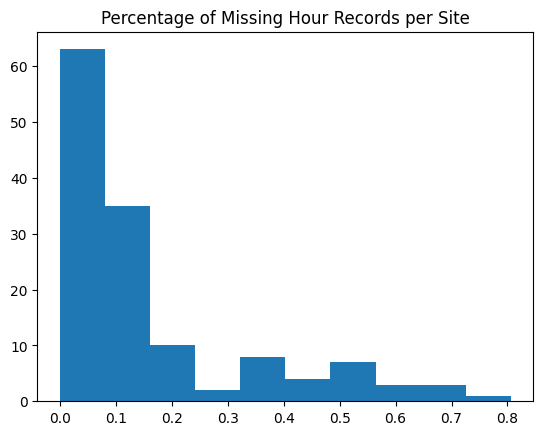

In [19]:
# Plot percentage of missing hourly records
plt.hist(site_missing_df['pct_hrs_missing'])
plt.title('Percentage of Missing Hour Records per Site')
plt.show()

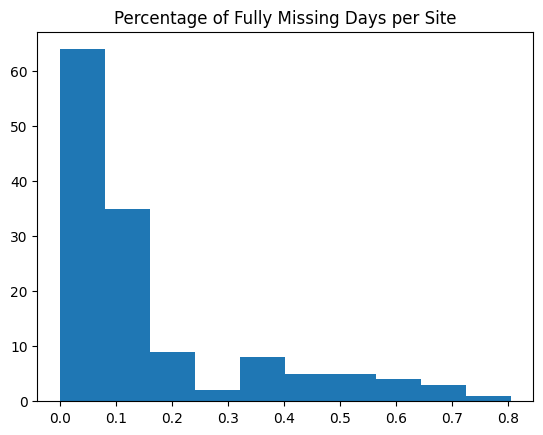

In [22]:
# Plot percentage of fully missing days
site_missing_df['total_days'] = site_missing_df['total_hours']//24
site_missing_df['pct_days_missing'] = site_missing_df['total_full_days_missing']/site_missing_df['total_days']
plt.hist(site_missing_df['pct_days_missing'])
plt.title('Percentage of Fully Missing Days per Site')
plt.show()

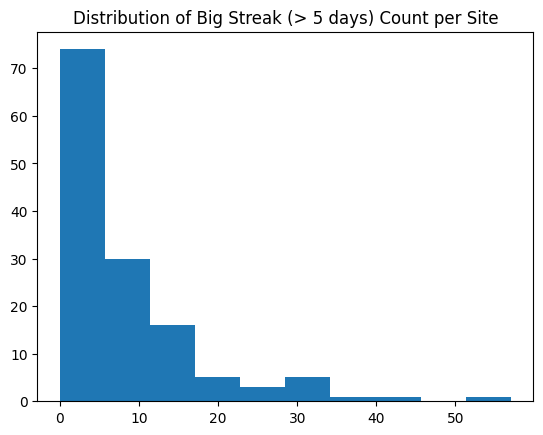

In [23]:
# Plot number of big streaks
plt.hist(site_missing_df['count_big_missing_streaks'])
plt.title('Distribution of Big Streak (> 5 days) Count per Site')
plt.show()

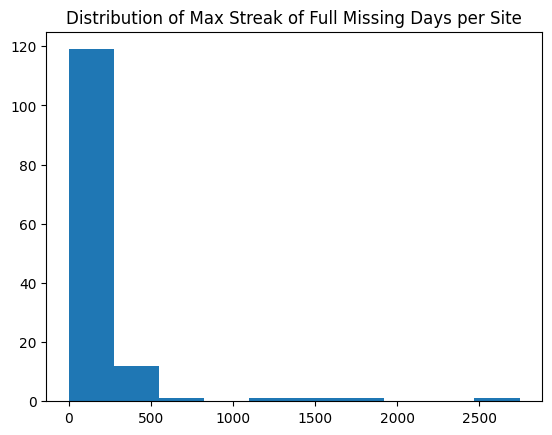

In [24]:
# Plot max day steak
plt.hist(site_missing_df['max_streak_len'])
plt.title('Distribution of Max Streak of Full Missing Days per Site')
plt.show()